In [1]:
import sys
sys.path.append('../')
from configs import cfg
import numpy as np

import cv2

from PIL import Image
from datasets import make_dataset 
from lib.utils.visualization import Visualizer
import matplotlib.pyplot as plt
import pdb
# %matplotlib notebook
config_file = '../configs/PIE_intent_action.yaml'

cfg.merge_from_file(config_file)
cfg.DATASET.ROOT = '../data/PIE_dataset'
# cfg.freeze()

In [2]:
dataset = make_dataset(cfg, split='train')

---------------------------------------------------------
Generating trajectory sequence data
fstride: 1
sample_type: all
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 0
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}
kfold_params: {'num_folds': 5, 'fold': 1}
max_size_observe: 30
max_size_predict: 5
seq_overlap_rate: 0.9
balance: False
crop_type: context
crop_mode: pad_resize
encoder_input_type: []
decoder_input_type: ['bbox']
output_type: ['intention_binary']
---------------------------------------------------------
Generating database for pie
pie annotations loaded from /home/brianyao/Documents/intention2021icra/data/PIE_dataset/data_cache/pie_database.pkl
---------------------------------------------------------
Generating intention data
Subset: train
Number of pedestrians: 880 
Total number of samples: 880 
Max_num_traffics:15, avg_num_traffics:2.00125
Dataset is already prepared!


In [3]:
cross_type = {0: 'not crossing', 1: 'crossing ego', -1: 'crossing others'}
action_type = {0: 'standing', 1: 'walking'}
intention_type = {0: 'will not cross', 1: "will cross"}
neighbor_class_to_name = {0:'pedestrian', 1:'car', 2:'truck', 3:'bus', 4:'train', 5:'bicycle', 6:'bike'}
traffic_light_state_to_name = {1:'red', 2:'yellow', 3:'green'}
traffic_light_class_to_name = {0:'regular', 1:'transit', 2:'pedestrian'}
traffic_sign_class_to_name = {0:'ped_blue', 1:'ped_yellow', 2:'ped_white', 3:'ped_text', 
                     4:'stop_sign', 5:'bus_stop', 6:'train_stop', 7:'construction', 8:'other'}

## Visualize the annotations on frames
* bounding boxes
* actions, intents and crossing status
* $224\times224$ patch 

In [4]:
ret = dataset.__getitem__(1324) # 1000, 950, 634
ret.keys()

dict_keys(['obs_bboxes', 'pred_bboxes', 'cur_image_file', 'resolution', 'image_files', 'pids', 'img_patches', 'local_bboxes', 'obs_intent', 'obs_action', 'pred_action', 'obs_crossing', 'neighbor_bboxes', 'neighbor_classes', 'neighbor_ids', 'traffic_light_bboxes', 'traffic_light_classes', 'traffic_light_states', 'traffic_sign_bboxes', 'traffic_sign_classes', 'crosswalk_bboxes', 'station_bboxes', 'obs_ego_motion', 'pred_ego_motion'])

In [47]:
ret = dataset.__getitem__(15000)
print(ret.keys())

image_files = ret['image_files']
intention = ret['obs_intent']
action = ret['obs_action'] 
crossing = ret['obs_crossing']
bboxes = ret['obs_bboxes']
img_patches = ret['img_patches']
neighbor_bboxes = ret['neighbor_bboxes'][0]
neighbor_classes = ret['neighbor_classes'][0]
traffic_light_bboxes = ret['traffic_light_bboxes'][0]
traffic_light_classes = ret['traffic_light_classes'][0]
traffic_light_states = ret['traffic_light_states'][0]
traffic_sign_bboxes = ret['traffic_sign_bboxes'][0]
traffic_sign_classes = ret['traffic_sign_classes'][0]
crosswalk_bboxes = ret['crosswalk_bboxes'][0]
station_bboxes = ret['station_bboxes'][0]

image_files = ret['image_files']
speed, heading_angle, yrp = ret['obs_ego_motion'][...,0], ret['obs_ego_motion'][...,1], ret['obs_ego_motion'][...,2:]
yaw = yrp[..., 0]


dict_keys(['obs_bboxes', 'pred_bboxes', 'cur_image_file', 'resolution', 'image_files', 'pids', 'img_patches', 'local_bboxes', 'obs_intent', 'obs_action', 'pred_action', 'obs_crossing', 'neighbor_bboxes', 'neighbor_classes', 'neighbor_ids', 'traffic_light_bboxes', 'traffic_light_classes', 'traffic_light_states', 'traffic_sign_bboxes', 'traffic_sign_classes', 'crosswalk_bboxes', 'station_bboxes', 'obs_ego_motion', 'pred_ego_motion'])


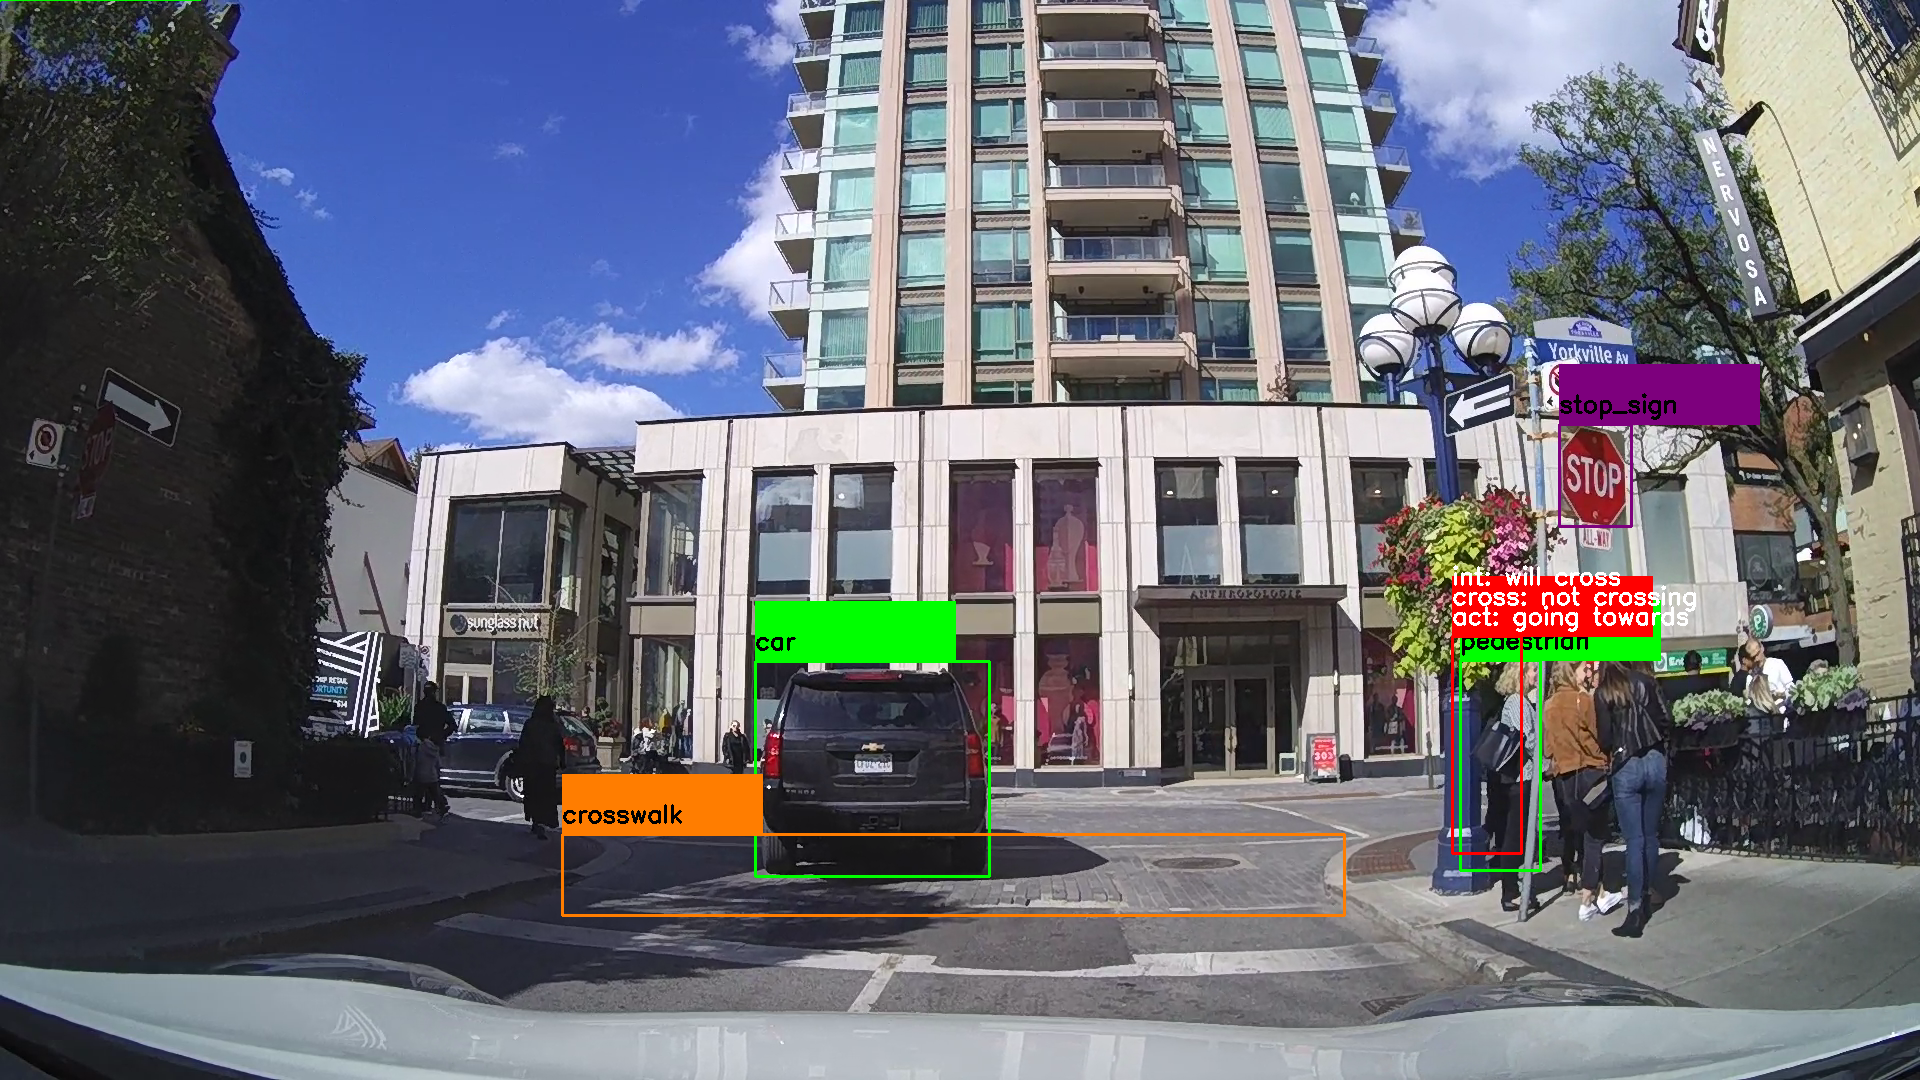

In [50]:
t = 29
viz = Visualizer(cfg, mode='image')
viz.initialize(img_path=image_files[t])
behaviors = {
                'intent':int(intention[t]), 
                'action':int(action[t]), 
                'crossing':int(crossing[t])
               }
# # get patch

# draw neighbor
if len(neighbor_bboxes) > 0:
    for nei_bbox, cls in zip(neighbor_bboxes[:, t], neighbor_classes[:,t]):
        viz.draw_single_bbox(nei_bbox, 
                             color=(0, 255., 0), 
                             class_label=neighbor_class_to_name[int(cls)])

# draw traffic light 
if len(traffic_light_bboxes) > 0:
    for light_bbox, cls, state in zip(traffic_light_bboxes[:,t], traffic_light_classes[:,t], traffic_light_states[:,t]):
        viz.draw_single_bbox(light_bbox, color=(0, 125, 255.), 
                             class_label=traffic_light_class_to_name[int(cls)],
                            state_label=traffic_light_state_to_name[int(state)])
# draw traffic sign
if len(traffic_sign_bboxes) > 0:
    for sign_bbox, cls in zip(traffic_sign_bboxes[:,t], traffic_sign_classes[:,t]):
        viz.draw_single_bbox(sign_bbox, 
                             color=(125, 0, 125.), 
                             class_label=traffic_sign_class_to_name[int(cls)])

# draw crosswalk and station
if len(crosswalk_bboxes) > 0:
    for crosswalk_bbox in crosswalk_bboxes[:,t]:
        viz.draw_single_bbox(crosswalk_bbox, color=(255., 125., 0), 
                             class_label='crosswalk')
if len(station_bboxes) > 0:
    for station_bbox in station_bboxes[:,t]:
        viz.draw_single_bbox(station_bbox, color=(255., 125., 0), 
                             class_label='transit station')
    
# draw target
viz.draw_single_bbox(bboxes[t], 
                     gt_behaviors=behaviors, 
                     color=(255., 0, 0))

viz_img = Image.fromarray(viz.img)
viz_img

## stats of PIE datasets
* \# Trajectories for train/val/test
* \# of Trajectories that has action/intention/crossing status changed
* \# of Trajectories for different action, intention and crossing combination.
* Distribution of object height (which indicates distance)

In [1]:
import sys
sys.path.append('../')
from configs import cfg
import numpy as np

from PIL import Image
from datasets import make_dataset 
from lib.utils.visualization import Visualizer
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from tqdm import tqdm

%matplotlib inline
sns.set()
config_file = '../configs/PIE_intent.yaml'

cfg.merge_from_file(config_file)
cfg.DATASET.ROOT = '../data/PIE_dataset'


In [2]:
cfg.DATASET.BALANCE = False
train_dataset = make_dataset(cfg, split='train')
# val_dataset = make_dataset(cfg, split='val')
# test_dataset = make_dataset(cfg, split='test')

---------------------------------------------------------
Generating trajectory sequence data
fstride: 1
sample_type: all
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 0
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}
kfold_params: {'num_folds': 5, 'fold': 1}
max_size_observe: 30
max_size_predict: 5
seq_overlap_rate: 0.9
balance: False
crop_type: context
crop_mode: pad_resize
encoder_input_type: []
decoder_input_type: ['bbox']
output_type: ['intention_binary']
---------------------------------------------------------
Generating database for pie
pie annotations loaded from /home/brianyao/Documents/intention2021icra/data/PIE_dataset/data_cache/pie_database.pkl
---------------------------------------------------------
Generating intention data
Subset: train
Number of pedestrians: 880 
Total number of samples: 880 
Dataset is already prepared!


In [112]:
# Get stats of all pedestrians
# intention_prob, intention_binary, action_seq, crossing_seq, ped_id
dataset = train_dataset
print(dataset.beh_seq.keys())
num_tracks = len(dataset.beh_seq['action_seq'])
seq_with_changed_intent = []
seq_with_changed_action = []
seq_with_changed_cross = []
track_lengths = []
object_heights = []
dependecy_matrix = np.zeros([2,2,3]) # intent, action, cross
crossing_labelled_as_will_not_cross = []

all_new_actions = []
dataset.beh_seq['new_action'] = []
for i, (bboxes, intent, action, cross) in enumerate(zip(dataset.beh_seq['bbox'],
                                             dataset.beh_seq['intention_binary'],
                                             dataset.beh_seq['action_seq'], 
                                             dataset.beh_seq['crossing_seq'])):
    
    track_lengths.append(len(intent))
    intent = [tmp[0] for tmp in intent]
    if abs(sum(intent) - intent[0] * len(intent)) > 1e-5:
        seq_with_changed_intent.append(i)
    if abs(sum(action) - action[0] * len(action)) > 1e-5:
        seq_with_changed_action.append(i)
    if abs(sum(cross) - cross[0] * len(cross)) > 1e-5:
        seq_with_changed_cross.append(i)
    
    crossed = False
    new_action_track = []
    for _int, _act, _cro, _box in zip(intent, action, cross, bboxes):
        _cro += 1
        if _cro in [0, 2]:
            crossed = True
        dependecy_matrix[_int, _act, _cro] += 1
        object_heights.append(_box[3] - _box[1])
        if _cro in [0, 2] and _int == 0:
            crossing_labelled_as_will_not_cross.append(i)
        # map to new action
        new_action = map_to_new_action(_int, _act, _cro, crossed)
        all_new_actions.append(new_action)
        new_action_track.append(new_action)
    dataset.beh_seq['new_action'].append(new_action_track)
print("# of tracks w\ intent change:{}, \
      w\o intent change:{}".format(len(seq_with_changed_intent), 
                                    num_tracks-len(seq_with_changed_intent)))
print("# of tracks w\ action change:{}, \
      w\o action change:{}".format(len(seq_with_changed_action), 
                                    num_tracks-len(seq_with_changed_action)))

print("# of tracks w\ cross change:{}, \
      w\o cross change:{}".format(len(seq_with_changed_cross), 
                                    num_tracks-len(seq_with_changed_cross)))
print("crossing_labelled_as_will_not_cross: ", len(crossing_labelled_as_will_not_cross))

dict_keys(['image', 'bbox', 'occlusion', 'intention_prob', 'intention_binary', 'action_seq', 'crossing_seq', 'resolution', 'ped_id', 'traffic_bbox', 'traffic_class', 'traffic_obj_id', 'obds_seq', 'head_ang_seq', 'yrp_seq', 'new_action'])
# of tracks w\ intent change:0,       w\o intent change:880
# of tracks w\ action change:153,       w\o action change:727
# of tracks w\ cross change:48,       w\o cross change:832
crossing_labelled_as_will_not_cross:  138


## We can make automatic labels of actions:
0. standing: intent is not crossing and is standing.
1. waiting: intent is crossing but is standing
2. going towards: intent is crossing but is walking and not crossing
3. crossing: current action is crossing
4. finished crossing and standing: had crossing action before and now is not crossing and standing
5. finished crossing and walking: had crossing action before and now is not crossing and walking
6. other walking: whole sequence do not have intent to cross and do not cross at all

([<matplotlib.axis.XTick at 0x7f8cd5068850>,
 <a list of 7 Text xticklabel objects>)

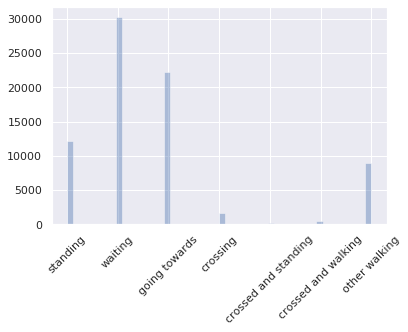

In [119]:
sns.distplot(all_new_actions,kde=False)
plt.xticks([0,1,2,3,4,5,6], 
           ['standing', 'waiting', 'going towards', 
            'crossing', 'crossed and standing', 'crossed and walking', 'other walking'],
          rotation=45)

In [104]:
def map_to_new_action(_int, _act, _cro, crossed):
    if _int == 0 and _act == 0 and _cro == 1 and not crossed:
        new_act = 0 # standing - have not crossed and will not cross
    elif _int == 1 and _act == 0 and _cro == 1 and not crossed:
        new_act = 1 # waiting - have not crossed yet and will cross
    elif _int == 1 and _act == 1 and _cro == 1 and not crossed:
        new_act = 2 # going towards - have not crossed yet and will cross
    elif _cro in [0, 2]:
        new_act = 3 # crossing
    elif crossed and _cro == 1 and _act == 0:
        new_act = 4 # finished crossing and standing
    elif crossed and _cro == 1 and _act == 1:
        new_act = 5 # finished crossing and walking
    elif _act == 1:
        new_act = 6 # other walking
    else:
        pdb.set_trace()
    return new_act

Text(0, 0.5, '# of pedestrians')

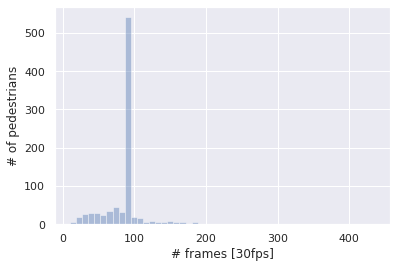

In [60]:
sns.distplot(track_lengths, kde=False)
plt.xlabel('# frames [30fps]')
plt.ylabel('# of pedestrians')

Text(0, 0.5, '# of pedestrians')

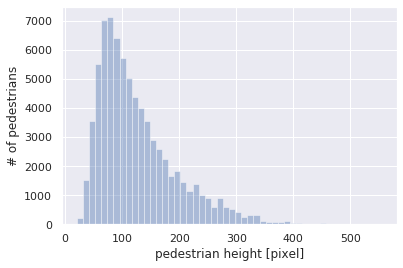

In [76]:
sns.distplot(object_heights, kde=False)
plt.xlabel('pedestrian height [pixel]')
plt.ylabel('# of pedestrians')